In [190]:
import time
from numpy import cos, pi, exp, e, sqrt
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [191]:
n_args_count_ = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max_ = 500  # больше 500 не нужно
number_of_agents_ = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight_ = 100  # максимальный вес рыбы

##Реализация алгоритма

In [192]:
@njit
def main_function(f, generate_agents, n_args_count, iter_max, number_of_agents, max_weight):
    y = 5

    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents(number_of_agents, n_args_count)  # Случано сгенерированное текущее поколение

    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list[t] = p_qbest

    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        delta_F = F[t] - F[t - 1]
        for i in range(number_of_agents):
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = numpy.sum(P_mul_F[:][j])
            I_t[j] = s
        I_t /= numpy.sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = numpy.sum(w[t])
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if numpy.sum(w[t]) > numpy.sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [193]:
def draw_graphic(f_val, functon_name, iter_max):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [194]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10) - 2,
                     numpy.zeros(10) + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [195]:
def start_test(f_, generate_agents_, function_name, n_args_count, iter_max, number_of_agents, max_weight):
    best_qbest_tests = numpy.zeros(10) # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function(f_, generate_agents_, n_args_count, iter_max, number_of_agents, max_weight)
        best = best_lst[-1]
        end = time.time() - start
        # best_qbest_tests.append(f(best))
        best_qbest_tests[i] = f_(best)
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f_(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        # f_val = [f(i) for i in best_lst]
        f_val = numpy.zeros(iter_max)
        for i in range(iter_max):
            f_val[i] = f_(best_lst[i])
        draw_graphic(f_val, function_name, iter_max)
    draw_distribution_graphic(best_qbest_tests, function_name)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [196]:
@njit
def f1(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i * i - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [197]:
@njit
def generate_agents1(number_of_agents, n_args_count):
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.00107461 0.00477166]
The function value of pqbest:		0.0047459060320065305
Algorithm running time:			4.736501932144165 s


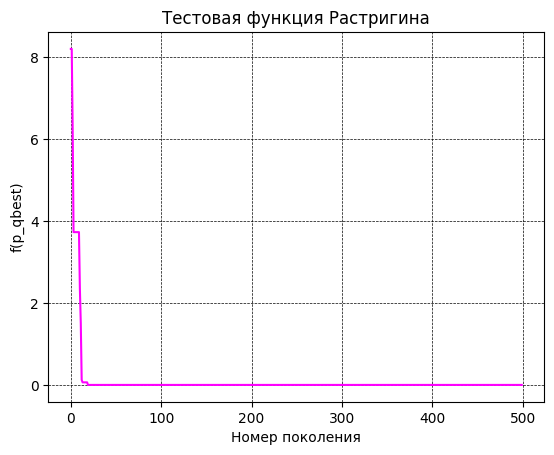

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.92849566 -0.06393483]
The function value of pqbest:		2.654649424343148
Algorithm running time:			0.032032012939453125 s


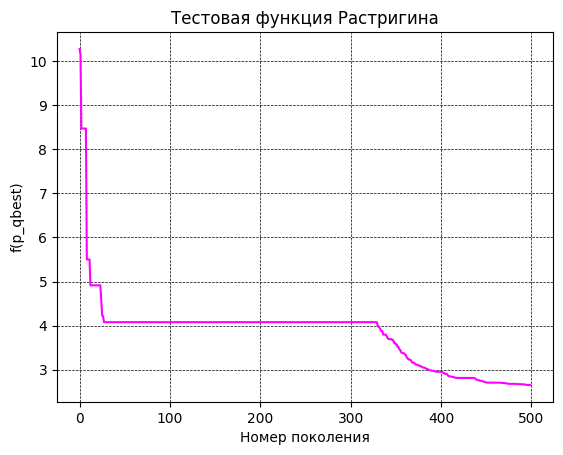

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.03329949 -0.02720678]
The function value of pqbest:		0.36568714765380506
Algorithm running time:			0.03200268745422363 s


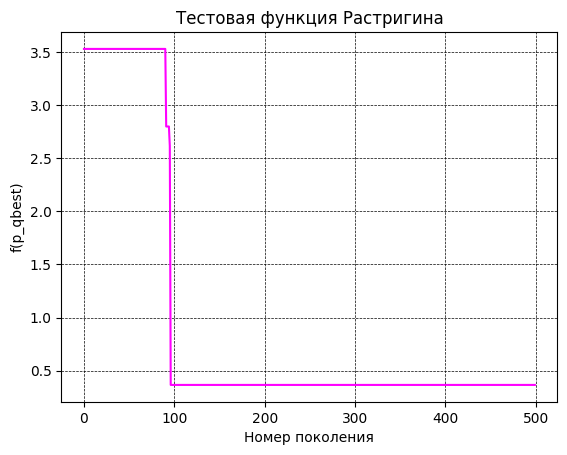

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.01583363 1.00894563]
The function value of pqbest:		1.0834601647189857
Algorithm running time:			0.0240170955657959 s


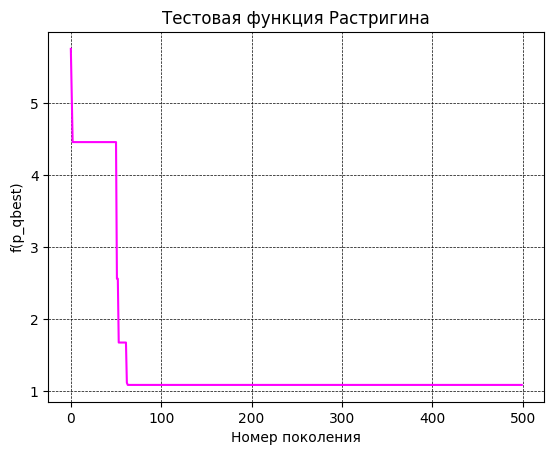

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 1.05181425 -1.09077193]
The function value of pqbest:		4.404182637626011
Algorithm running time:			0.02896857261657715 s


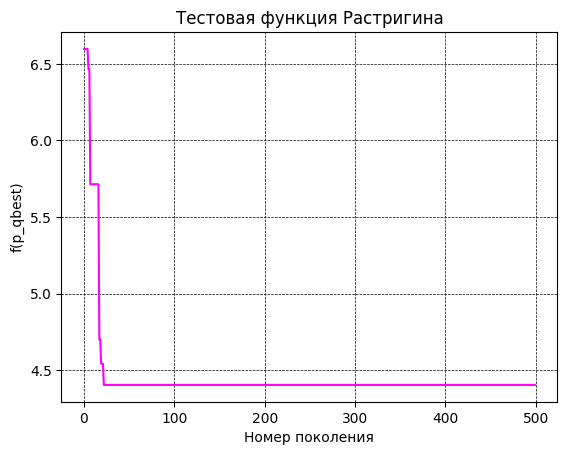

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[1.10599134 0.01136294]
The function value of pqbest:		3.385601370566402
Algorithm running time:			0.04802203178405762 s


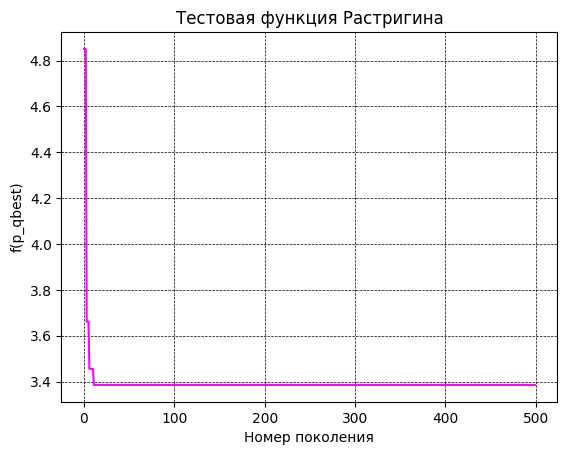

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.03366501  1.02749071]
The function value of pqbest:		1.4285549760904601
Algorithm running time:			0.03200650215148926 s


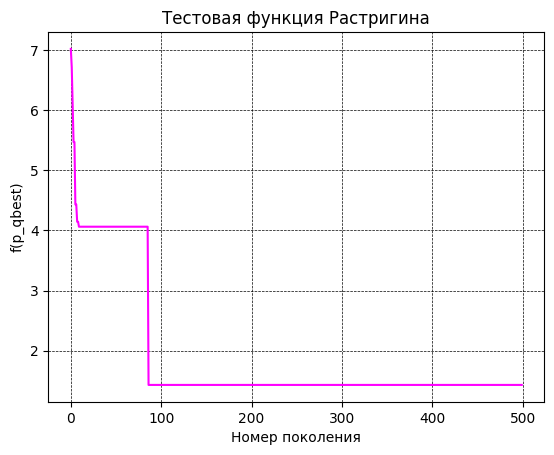

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.98755502 -0.92901737]
The function value of pqbest:		2.847083895947108
Algorithm running time:			0.03999757766723633 s


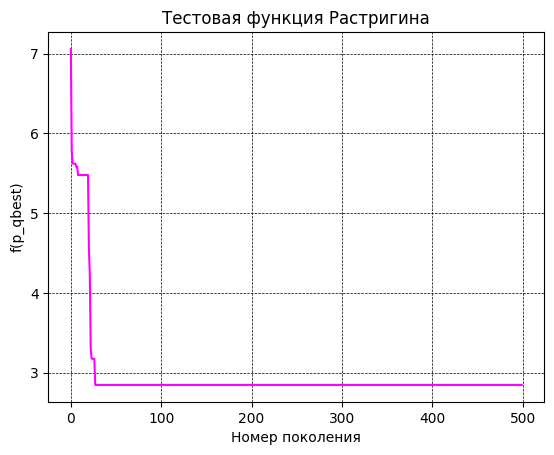

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[1.97635778 0.01963217]
The function value of pqbest:		4.09248879960977
Algorithm running time:			0.03199934959411621 s


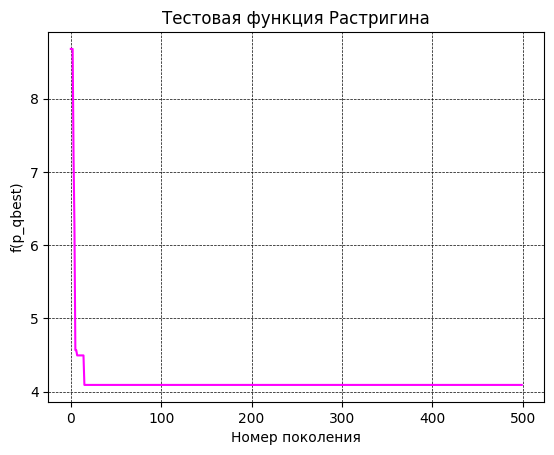

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.93798335 -1.00143691]
The function value of pqbest:		2.6327214232337433
Algorithm running time:			0.03198671340942383 s


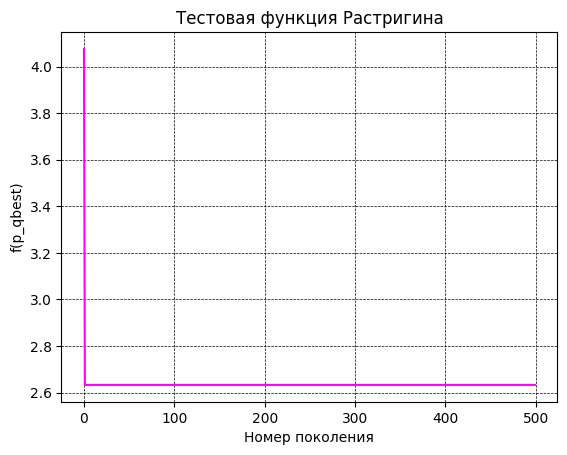

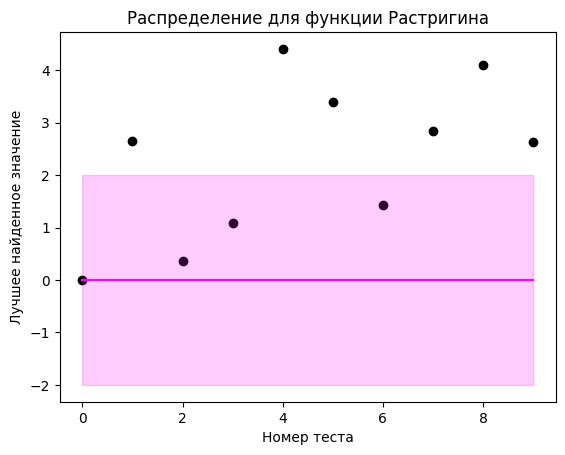

In [198]:
start_test(f1, generate_agents1, "Растригина", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [199]:
@njit
def f2(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * sqrt(0.5 * (x[0] * x[0] + x[1] * x[1]))) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [200]:
@njit
def generate_agents2(number_of_agents, n_args_count):
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.14685132 0.17028064]
The function value of pqbest:		1.6249273763020717
Algorithm running time:			3.5962460041046143 s


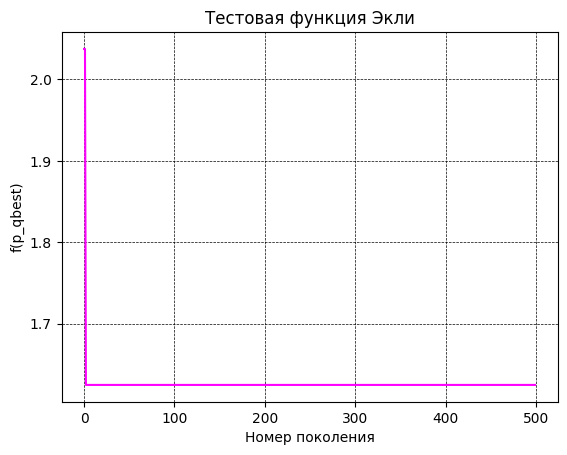

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 0.09457457 -1.01723538]
The function value of pqbest:		2.9211176407669655
Algorithm running time:			0.01600193977355957 s


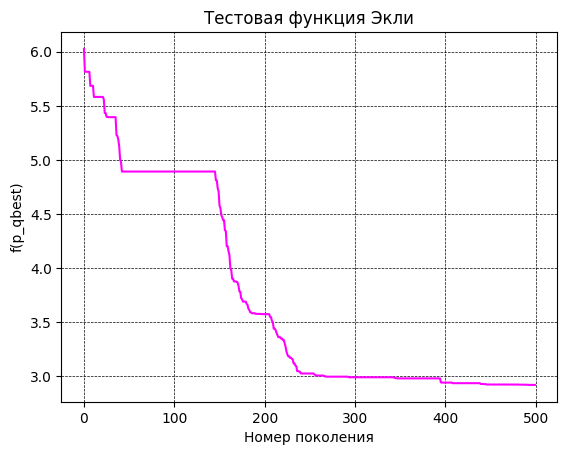

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[0.01173561 0.91667413]
The function value of pqbest:		2.6114543991760932
Algorithm running time:			0.02401447296142578 s


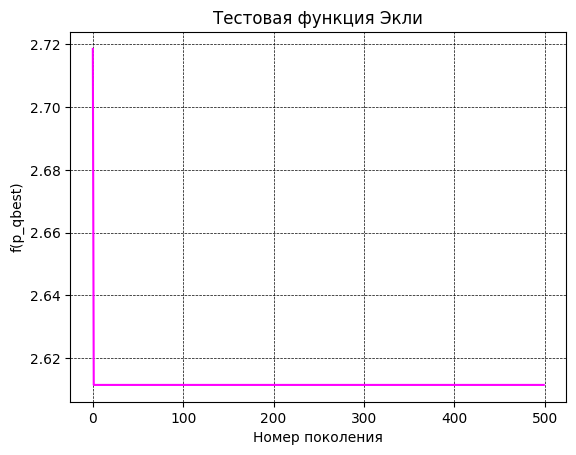

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.0022791   0.00034368]
The function value of pqbest:		0.006660614644889762
Algorithm running time:			0.01600360870361328 s


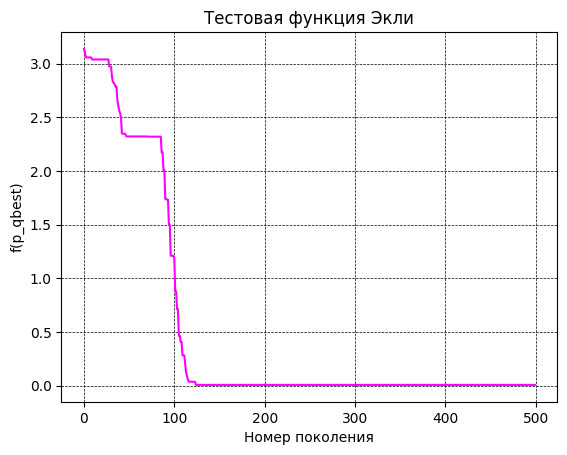

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.06863012 -0.12417769]
The function value of pqbest:		0.8685632864186381
Algorithm running time:			0.024012088775634766 s


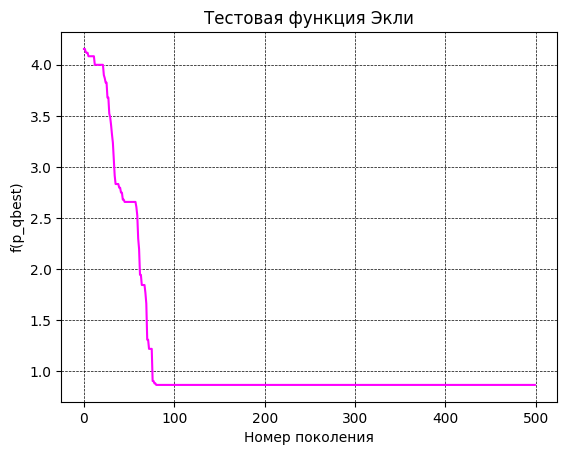

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.0674354  -0.49340886]
The function value of pqbest:		3.121212330678304
Algorithm running time:			0.01600193977355957 s


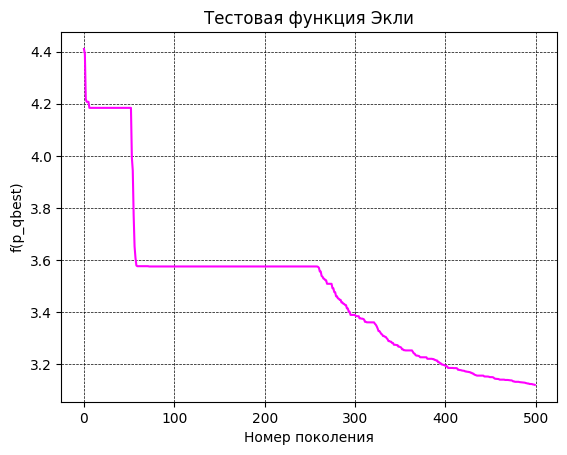

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[0.00175942 0.01518877]
The function value of pqbest:		0.049461287009780364
Algorithm running time:			0.0240018367767334 s


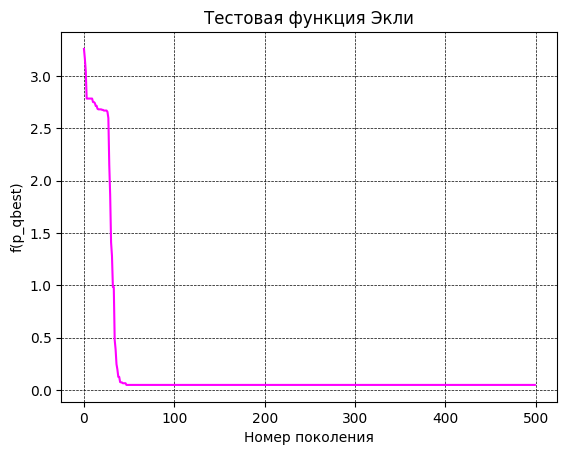

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.00078633 0.00055182]
The function value of pqbest:		0.0027416736566721056
Algorithm running time:			0.023990392684936523 s


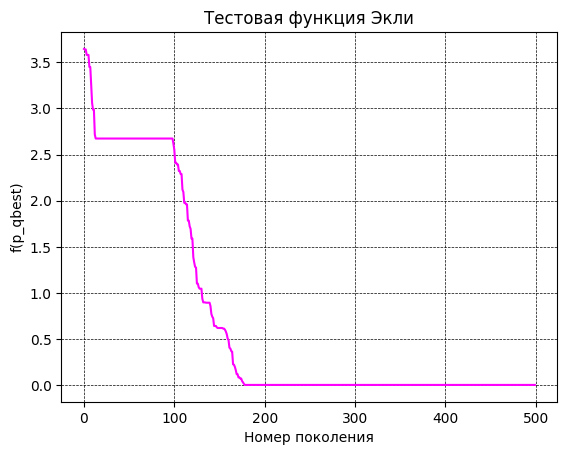

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.06667231 -0.03255096]
The function value of pqbest:		0.35076259757940775
Algorithm running time:			0.02401590347290039 s


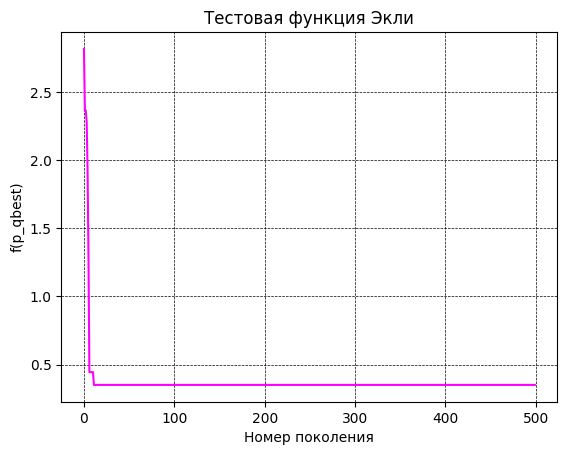

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.21152698  0.1481655 ]
The function value of pqbest:		1.9162968437438188
Algorithm running time:			0.024003267288208008 s


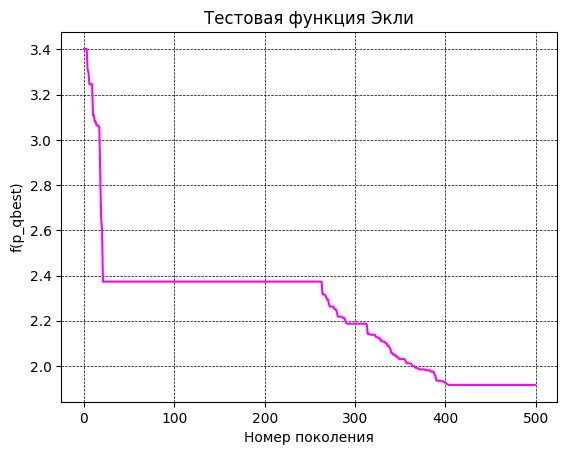

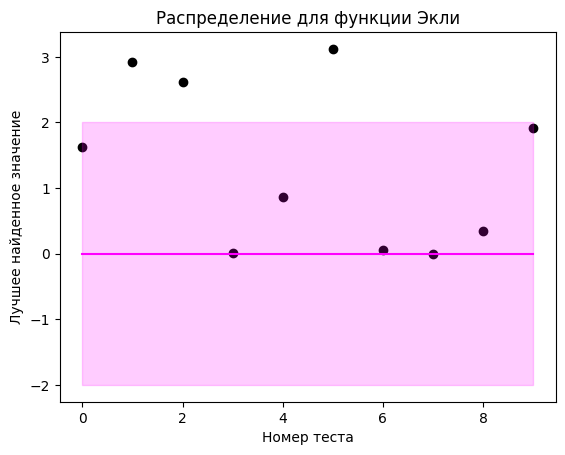

In [201]:
start_test(f2, generate_agents2, "Экли", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [202]:
@njit
def f3(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i * i
    return result

##Генерация начальных агентов

In [203]:
@njit
def generate_agents3(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.79739367  0.343893  ]
The function value of pqbest:		0.7540990557485103
Algorithm running time:			2.8509609699249268 s


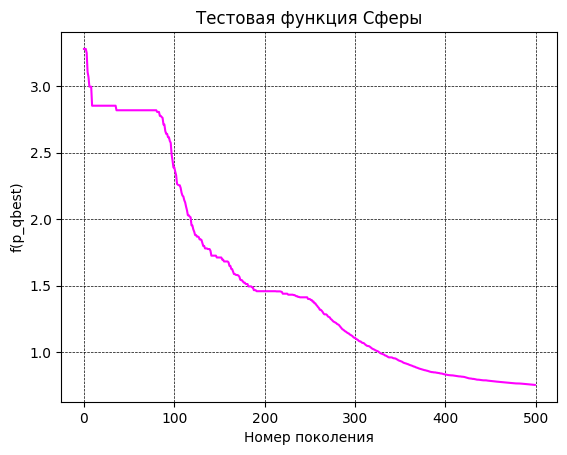

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 0.15988413 -0.37469284]
The function value of pqbest:		0.16595765595683
Algorithm running time:			0.015918254852294922 s


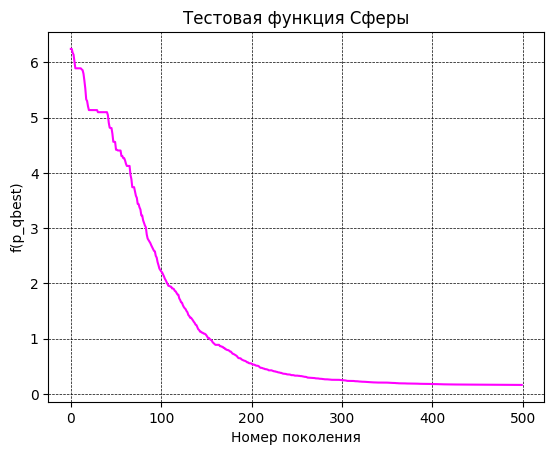

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.00017752  0.00120191]
The function value of pqbest:		1.4760928767706288e-06
Algorithm running time:			0.01600170135498047 s


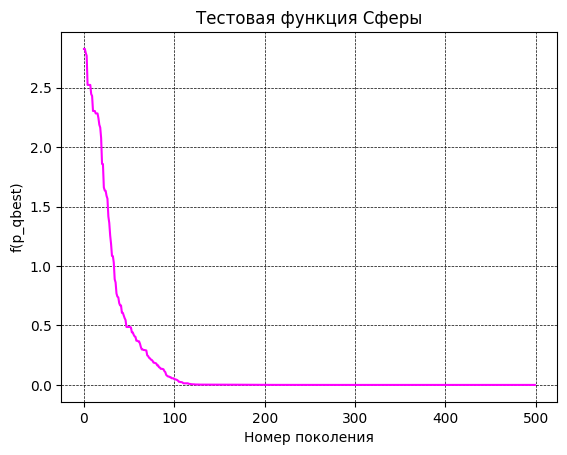

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.00130411 -0.00058483]
The function value of pqbest:		2.0427289160929545e-06
Algorithm running time:			0.024003028869628906 s


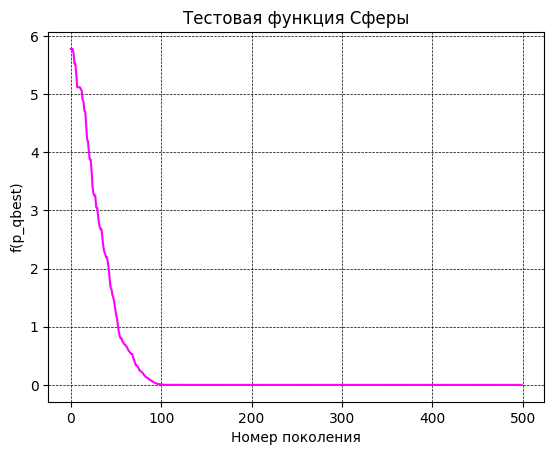

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.00033599 -0.00146313]
The function value of pqbest:		2.2536429965386177e-06
Algorithm running time:			0.016002178192138672 s


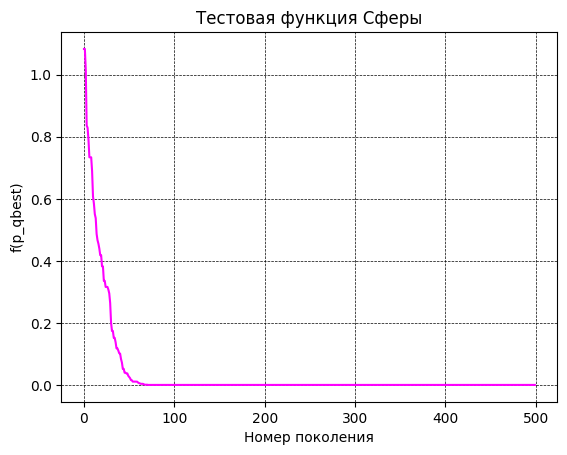

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.00321309 -0.0496105 ]
The function value of pqbest:		0.002471525831918216
Algorithm running time:			0.0240018367767334 s


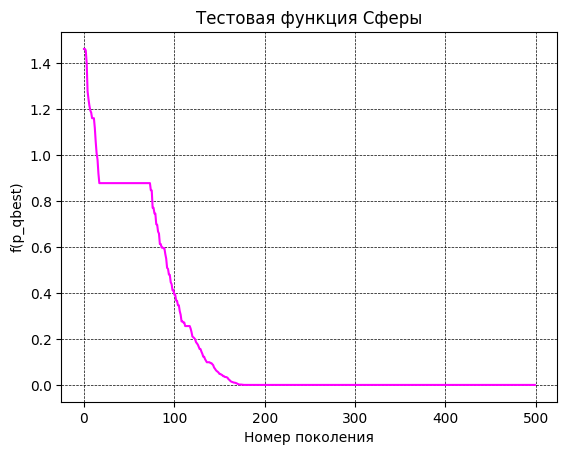

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.54128756  0.1799622 ]
The function value of pqbest:		0.325378611191476
Algorithm running time:			0.0240020751953125 s


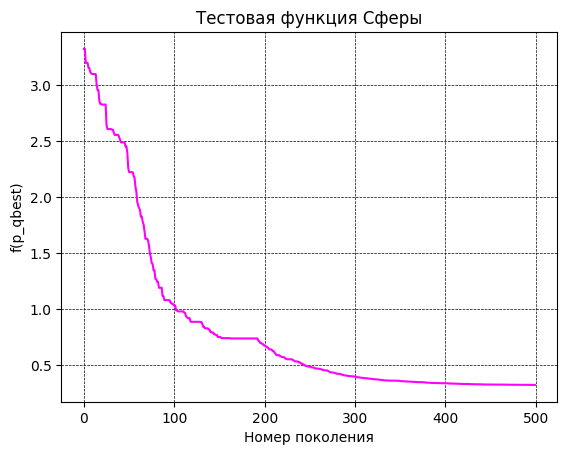

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.34094118 -0.33452908]
The function value of pqbest:		0.2281505942817308
Algorithm running time:			0.023756980895996094 s


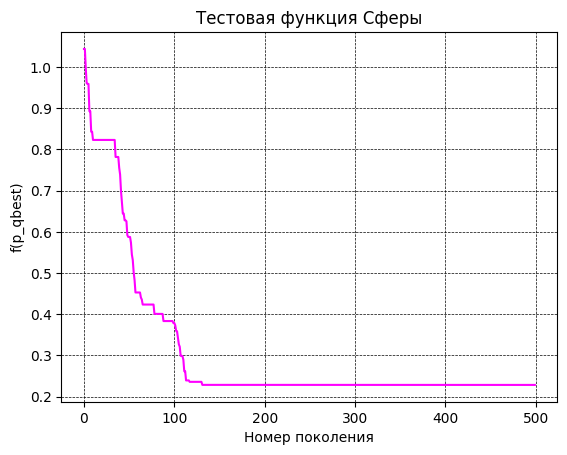

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[0.70701845 0.34498809]
The function value of pqbest:		0.6188918727318868
Algorithm running time:			0.015880107879638672 s


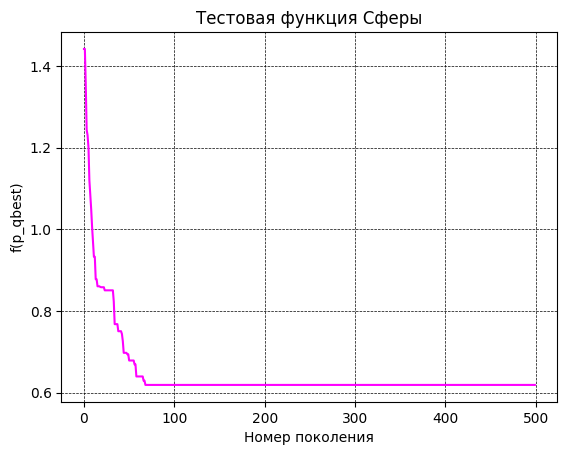

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 1.4358582  -0.42148933]
The function value of pqbest:		2.239342018888266
Algorithm running time:			0.024016380310058594 s


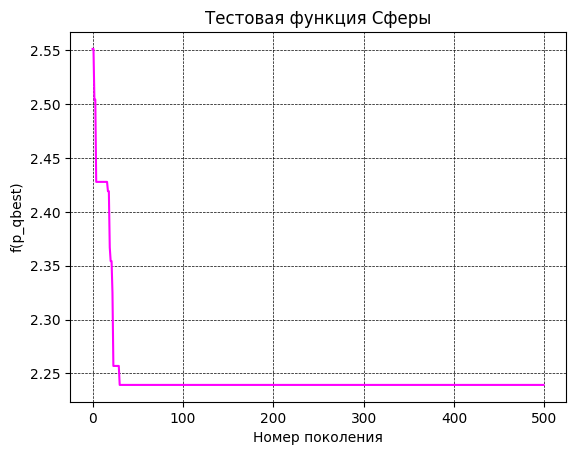

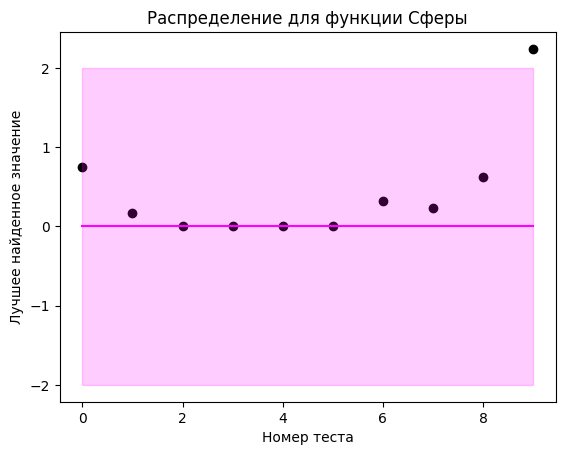

In [204]:
start_test(f3, generate_agents3, "Сферы", n_args_count_, iter_max_, number_of_agents_, max_weight_)
